# Basic regression: Predict fuel efficiency

https://www.tensorflow.org/tutorials/keras/regression

## Import Keras

In [1]:
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


## The Auto MPG Dataset

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Data Cleaning

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop the NAN row.

In [6]:
dataset = dataset.dropna()

One-hot coding. The "Origin" column is really categorical, not numeric. So convert that to a one-hot.

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Data Split

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Data Inspection

Quick look data joint distribution

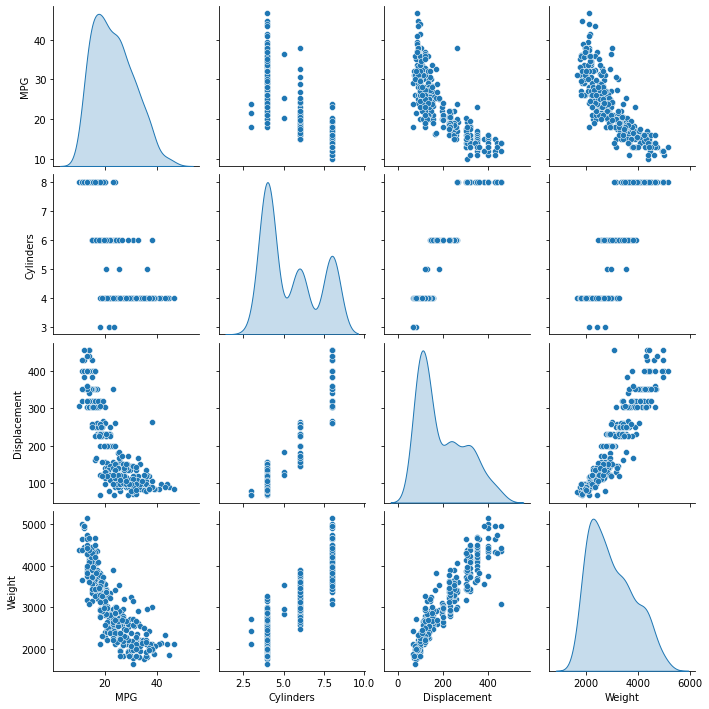

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Normalization

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

Reason is about the optimizer gradient.

In [11]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [13]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression model

### One Variable Model

Start with one variable model. Predict MPG from Horsepower. `y = weight * x + bias`

In [14]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [15]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Take a glance of untrained model with first 10 results.

In [16]:
horsepower_model.predict(horsepower[:10])

array([[-0.582],
       [-0.329],
       [ 1.075],
       [-0.816],
       [-0.738],
       [-0.29 ],
       [-0.875],
       [-0.738],
       [-0.192],
       [-0.329]], dtype=float32)

In [17]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [18]:
%%time

epochs = 100

history = horsepower_model.fit(
    train_features['Horsepower'], 
    train_labels,
    epochs=epochs,
    verbose=0,
    validation_split=0.2
)

Wall time: 4.99 s


In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804089,4.174613,95
96,3.806977,4.173222,96
97,3.804839,4.209777,97
98,3.806740,4.191412,98
99,3.803786,4.200545,99


In [20]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

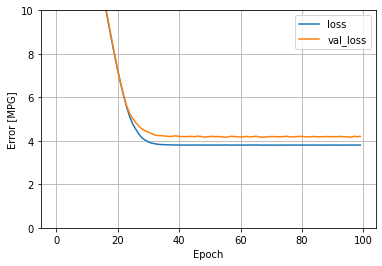

In [21]:
plot_loss(history)

Collect the result on the test set, for later:

In [22]:
test_results = {}
test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

#### Draw the model input output relationship

In [23]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [24]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

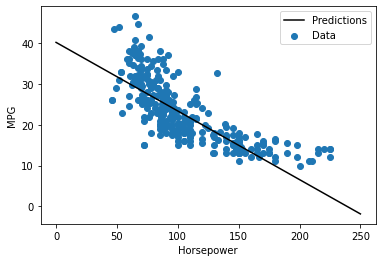

In [25]:
plot_horsepower(x, y)

### Multiple Inputs Model

In [26]:
linear_model = tf.keras.Sequential([
    normalizer, # use fully parameters normalizer input layer
    layers.Dense(units=1)
])

In [27]:
linear_model.predict(train_features[:10])

array([[-0.512],
       [-0.057],
       [-1.065],
       [ 1.243],
       [ 1.118],
       [-0.01 ],
       [ 1.013],
       [ 1.066],
       [-0.812],
       [-0.783]], dtype=float32)

In [28]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.036],
       [ 0.149],
       [-0.637],
       [ 0.216],
       [-0.576],
       [ 0.722],
       [-0.04 ],
       [-0.194],
       [-0.732]], dtype=float32)>

In [29]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [30]:
%%time

epochs = 100

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    verbose=0,
    validation_split=0.2
)

Wall time: 5.43 s


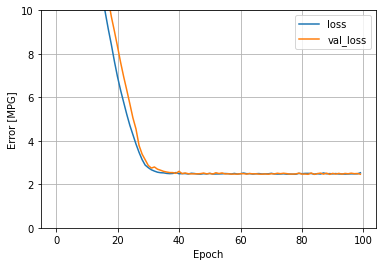

In [31]:
plot_loss(history)

In [32]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

## DNN Regression

In [71]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )
    
    return model

### One Variable

In [72]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [73]:
dnn_horsepower_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_18 (Dense)             (None, 4096)              8192      
_________________________________________________________________
dense_19 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_20 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_21 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 4097      
Total params: 50,356,228
Trainable params: 50,356,225
Non-trainable params: 3
__________________________________________

In [74]:
%%time

epochs=1000

history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    verbose=0,
    epochs=epochs,
    validation_split=0.2
)

Wall time: 1min 21s


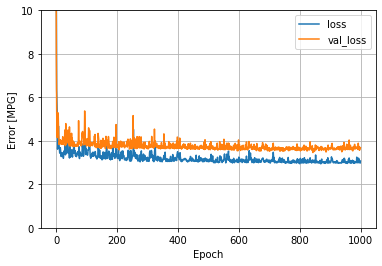

In [75]:
plot_loss(history)

In [57]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

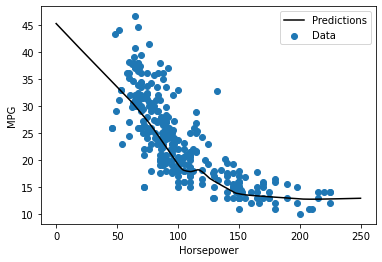

In [58]:
plot_horsepower(x, y)

In [59]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

### Full Parameters Model

In [60]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              10240     
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 1025      
Total params: 3,160,084
Trainable params: 3,160,065
Non-trainable params: 19
___________________________________________

In [61]:
%%time

epochs=100

history = dnn_model.fit(
    train_features,
    train_labels,
    verbose=0,
    epochs=epochs,
    validation_split=0.2
)

Wall time: 6.23 s


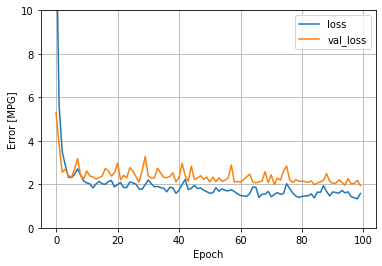

In [62]:
plot_loss(history)

In [63]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance Summary

In [64]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651289
linear_model,2.450254
dnn_horsepower_model,3.229016
dnn_model,2.099385
reloaded,1.746888


### Predictions

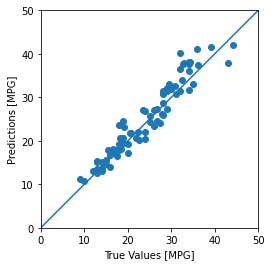

In [65]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

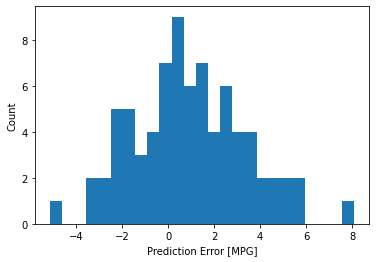

In [66]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

### Model Benchmark

In [67]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [68]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [69]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651289
linear_model,2.450254
dnn_horsepower_model,3.229016
dnn_model,2.099385
reloaded,2.099385


In [70]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]